# Handwritten digit classification with  Perceptron

* Perceptron can only handle binary classification. So we are going to classify the handwritten image as zero and not zero. 
* Dataset: [MNIST](https://en.wikipedia.org/wiki/MNIST_database)

In [11]:
# Common Imports
import numpy as np
import pandas as pd
import os
import io
import warnings

#skearn importts
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# make pretty images
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

The data matrix X and the respective label vector y need to be converted to numpy array

In [3]:
X = X.to_numpy()
y = y.to_numpy()

* Let's look at information like number of features, number of classes etc about the dataset.

In [8]:
target_names = np.unique(y)
print('Number of samples: {0}, type: {1}'.format(X.shape[0], X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum:{0}, Maximum:{1}'.format(np.min(X), np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names), y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type: float64
Number of features: 784
Minimum:0.0, Maximum:255.0
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


* The feature values are pixel values of 28 x 28 pixel images, and the value ranges between 0 and 255.
* Let's first scale the values to a [0,1]. We can use either `MinMaxScaler` or `MaxAbsScaler`.

In [9]:
X = MinMaxScaler().fit_transform(X)
print('Minimum:{0}, Maximum:{1}'.format(np.min(X), np.max(X)))

Minimum:0.0, Maximum:1.0


### Visualisation

Let's pick a few images and display them


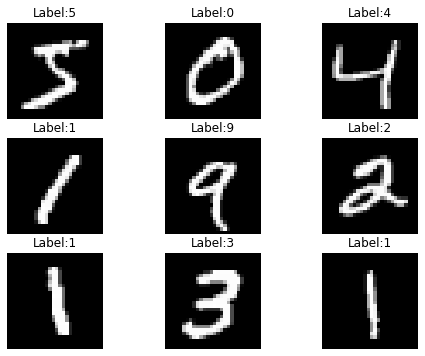

In [13]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Label:{0}'.format(str(y[index + j])))
        ax[i, j].set_axis_off()


## Data Splitting

* Let's use a train-test split ratio of 0.6. Since the images are already randomly shuffled we need not use `train_test_spit`.

In [25]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

* Before proceeding further, we need to check whether the dataset is balanced or  imbalanced. We can do it by plotting the distribution of sampls in each classes.

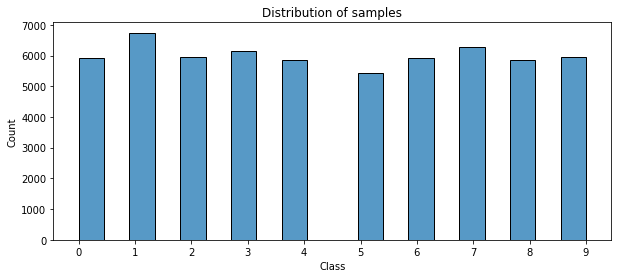

In [26]:
plt.figure(figsize=(10,4))
sns.histplot(data = np.int8(y_train), binwidth = 0.45, bins = 11)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## Binary Classification: 0-Detector


### Modifying Labels

* We are trying to implement binary classifier which can detect 0 from the handwritten digits. 
* We will relabel the samples such that the label 0 will be chnaged to 1 and all otherr labels(1-9) will be changed to -1.

In [27]:
# Initialize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

#find indices of the digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1

indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

#### Sanity check

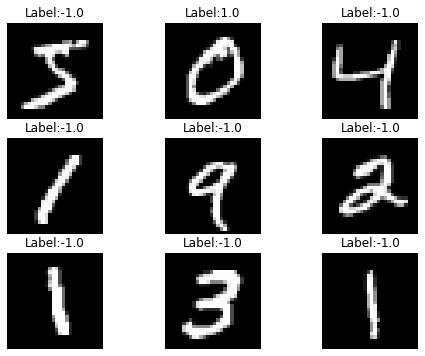

In [28]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Label:{0}'.format(str(y_train_0[index + j])))
        ax[i, j].set_axis_off()


### Baseline Models

Let's quickly construct a baseline model witht he following rule

1. Count the number of samples per class
2. The model always outputs the class which has highest number of samples.
3. Then calculate teh accuracy of the baseline model.

In [29]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])
print(num_pos, num_neg)

5923 54077


In [30]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(x_train, y_train_0)
print('Training accuracy:{0:0.2f}'.format(base_clf.score(x_train, y_train_0)))
print('Testing accuracy:{0:0.2f}'.format(base_clf.score(x_test, y_test_0)))

Training accuracy:0.90
Testing accuracy:0.90


### Perceptron model


In [31]:
#Instantiate the model
bin_clf  = Perceptron(max_iter=100, random_state=1729)

#Train
bin_clf.fit(x_train, y_train_0)

#Results
print('Dimension of weight w: {0}'.format(bin_clf.coef_.shape))
print('Bias: {0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimension of weight w: (1, 784)
Bias: [-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x00000203418039F0>


Let's evaluate our model

In [33]:
print('Training Accuracy: ', bin_clf.score(x_train, y_train_0))
print('Test Accuracy: ', bin_clf.score(x_test, y_test_0))

Training Accuracy:  0.99095
Test Accuracy:  0.989


### Displaying predictions

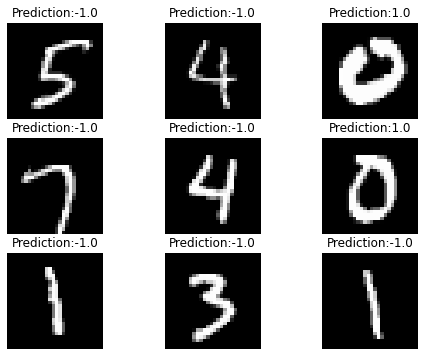

In [43]:
y_hat_test_0 = bin_clf.predict(x_test)

num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = np.random.randint(0, int(len(x_test)/2)) # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(x_test[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index + j])))
        ax[i, j].set_axis_off()

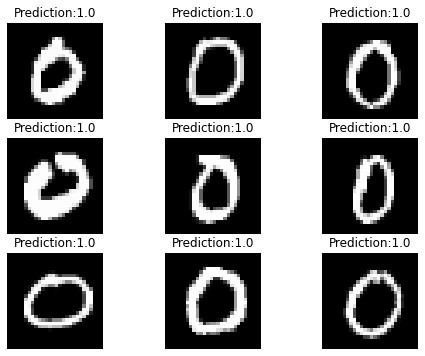

In [46]:
indx_0 = np.where(y_test_0 == 1)

zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]

num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(zeroImgs[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Prediction:{0}'.format(str(zeroLabls[index + j])))
        ax[i, j].set_axis_off()

### Confusion matrix

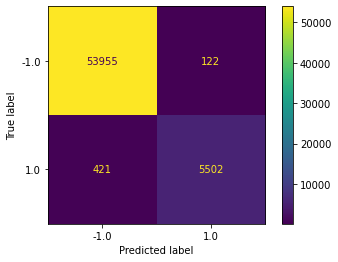

In [47]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

### Precision and Recall

In [49]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp + fp)
recall = tp/(tp + fn)
accuracy = (tn + tp)/ (tn + fn + fp + tp)

print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)


Precision:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy:  0.99095


### Cross validation

In [50]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, x_train, y_train_0, cv=5, 
                        scoring=['precision', 'recall', 'f1'],
                        return_estimator=True)

pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([0.86346769, 1.75436354, 1.22942305, 1.10378504, 1.26299787]),
 'score_time': array([0.04729104, 0.03126502, 0.03500414, 0.02901959, 0.02800107]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


Average and standard deviation of the metrics

In [51]:
print('f1,        avg:{0:.2f}, std:{1:.3f}'.format(scores['test_f1'].mean(), scores['test_f1'].std()))
print('precision, avg:{0:.2f}, std:{1:.2f}'.format(scores['test_precision'].mean(), scores['test_precision'].std()))
print('f1,        avg:{0:.2f}, std:{1:.2f}'.format(scores['test_recall'].mean(), scores['test_recall'].std()))

f1,        avg:0.94, std:0.013
precision, avg:0.96, std:0.01
f1,        avg:0.92, std:0.03


* Let's pick the first estimator and hope that it has better performance on the test data

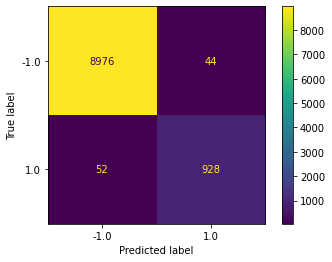

In [53]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')
plt.show()

In [54]:
print('Precision %.2f' %precision_score(y_test_0, y_hat_test_0))
print('Recall %.2f' %recall_score(y_test_0, y_hat_test_0))

Precision 0.95
Recall 0.95


### Another way to generalise

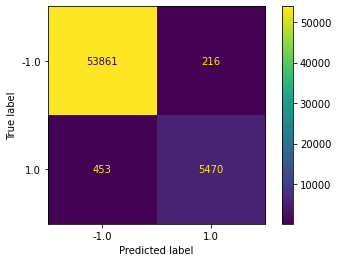

In [55]:
y_hat_train_0 = cross_val_predict(bin_clf, x_train, y_train_0, cv=5)

cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [56]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp + fp)
recall = tp/(tp + fn)
accuracy = (tn + tp)/ (tn + fn + fp + tp)

print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)

Precision:  0.9620119591980303
Recall:  0.9235184872530812
Accuracy:  0.98885


In [57]:
print('Precision %.2f' %precision_score(y_train_0, y_hat_train_0))
print('Recall %.2f' %recall_score(y_train_0, y_hat_train_0))
print('-'*50)
print(classification_report(y_train_0, y_hat_train_0))

Precision 0.96
Recall 0.92
--------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



### Precision - Recall Tradeoff

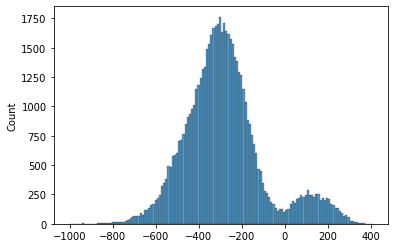

In [58]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(x_train, y_train_0)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

* Class imbalance
* Suppose threshold talkes the value of -600, then all the samples having score greater than -600  is set to 1 and less than it is set to -1.
* On the other hand, if the threshold takes the value of, say, 400. Then, the number of false negatives will increase and recall will reduce to a great extend.

Let's see it in action

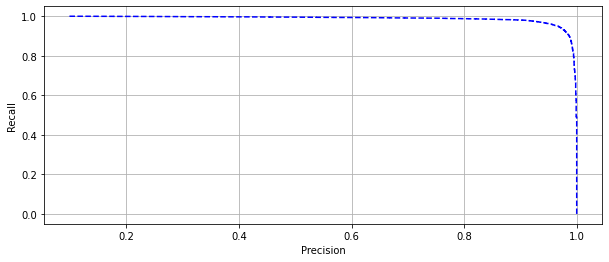

In [60]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

plt.figure(figsize=(10,4))
plt.plot(precisions[:-1], recalls[:-1], "b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

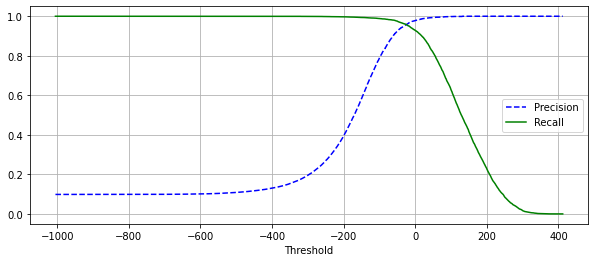

In [64]:
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.grid(True)
plt.legend()
plt.show()

### The ROC Curve

In [65]:
from sklearn.metrics import roc_curve

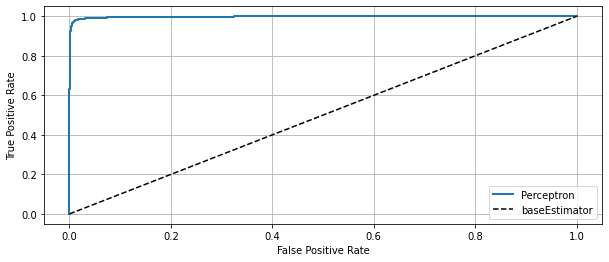

In [66]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label = 'Perceptron')
plt.plot([0, 1], [0,1], 'k--', label = 'baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()